In [1]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LdaMulticore, CoherenceModel

import tqdm
import pyLDAvis
import pyLDAvis.gensim
from pprint import pprint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fivecentsly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('recipe_clean.csv')
df.head(1)

,link,title,ratings,num_reviews,ingredients,servings,cook_time,calorie,fat_g,carb_g,protein_g,cholesterol_mg,sodium_mg
0,https://www.allrecipes.com/recipe/100164/chip-...,Chip Truck Fries,4.44,44,"['6 baking potatoes, cut into 1/4 inch slices'...",4.0,60,369.0,14.0,56.3,6.5,0.0,478.0


In [3]:
df.shape

(4776, 13)

# Preprocess

In [4]:
# keep title and ingredients for text cleaning
df = df[['title', 'ingredients']]
df.ingredients[0]

"['6 baking potatoes, cut into 1/4 inch slices', '1/4 cup vegetable oil', '2 teaspoons seasoned salt']"

In [5]:
# define a function to convert list to str
def list_to_str(x):
    """
    Convert list to str
    """
    # extract list from str
    x = ast.literal_eval(x)
    
    # convert list to str
    x = ','.join(x)

    return x

In [6]:
# apply function to df
df.ingredients = df.ingredients.apply(list_to_str)
df.ingredients[0]

'6 baking potatoes, cut into 1/4 inch slices,1/4 cup vegetable oil,2 teaspoons seasoned salt'

### Remove number and punctuation

In [7]:
# create a list for text data
data = df.ingredients.values.tolist()

# remove number and punctuation
data = [re.sub(r'[^a-zA-Z]', ' ', sent.lower()) for sent in data] 
data[0]

'  baking potatoes  cut into     inch slices     cup vegetable oil   teaspoons seasoned salt'

In [8]:
# remove units
units = ['spoon','pound','cup','quart','ounce','pint','degree','dash','pinch','pack','halve','bunch','inch']
for unit in units:
    expre = re.compile('\w*' + unit + '\w*')
    data = [re.sub(expre, '', sent).strip() for sent in data]

data[0]

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-8-33fd2784d652>:4: DeprecationWarning: invalid escape sequence \w
  expre = re.compile('\w*' + unit + '\w*')
<ipython-input-8-33fd2784d652>:4: DeprecationWarning: invalid escape sequence \w
  expre = re.compile('\w*' + unit + '\w*')


'baking potatoes  cut into      slices      vegetable oil    seasoned salt'

In [9]:
# remove duplicated whitespace
data = [' '.join(sent.split()) for sent in data]

data[0]

'baking potatoes cut into slices vegetable oil seasoned salt'

### Tokenize words

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(sentence))

data_words = list(sent_to_words(data))
data_words[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Make bigram

In [11]:
# build a bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 

# faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [12]:
data_bigram = [bigram_mod[doc] for doc in data_words]
data_bigram[0]

['baking',
 'potatoes',
 'cut',
 'into',
 'slices',
 'vegetable',
 'oil',
 'seasoned',
 'salt']

### Remove stopwords and lemmatize

In [13]:
stop_words = stopwords.words('english')

# remove stopwords
data_nonstop = [[word for word in doc if word not in stop_words] for doc in data_bigram]
data_nonstop[0]

['baking', 'potatoes', 'cut', 'slices', 'vegetable', 'oil', 'seasoned', 'salt']

In [14]:
# keep only noun and adj
def lemmatization(texts, allowed_postags=['NOUN','ADJ']): 
    texts_out = []
    for sent in texts:
        doc = nlp(' '.join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# initialize spacy 'en' model, keeping only tagger component
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatize
data_lemmatized = lemmatization(data_nonstop, allowed_postags=['NOUN','ADJ'])
data_lemmatized[0]

['potato', 'slice', 'vegetable', 'oil', 'salt']

In [15]:
# check word frequencies
vocab = dict()
for doc in data_lemmatized:
    for word in doc:
        if word not in vocab.keys():
            vocab[word] = 1
        else:
            vocab[word] += 1

In [23]:
len(vocab)

1254

In [16]:
# vocab

In [17]:
# self-define stopwords
recipe_stopwords = ['slice','large','diced','stock','taste','leave','powder','sliced','fresh','low','fat',
                    'whole','purpose','mix','ripe','medium','raw','coarse','style','active','dry','ground',
                    'white','heart','piece','crushed','cut','minute','pocket','shredded','optional','cube',
                    'hour','bag','baby','seeded','small','clove','country','leaf','dressing','center','fillet',
                    'sea','chunk','light','food','head','container','link','frozen','can','cooked','stalk',
                    'regular','dusting','heavy','round','rinsed','thawed','jar','solid','creamy','z','fluid',
                    'uncooked','sheet','strip','short','soft','mixed','blue','flake','warm','unbleached','sun',
                    'old','topping','wedge','thick','lean','extra','meal','preserve','mild','half','crosswise',
                    'new','seasoning','kidney','black','green','red','yellow','white','unpeeled','boiling',
                    'amount','cold','snow','cluster','necessary','firm','soda','cubed','temperature','deep',
                    'flat','iron','seedless','boneless','strong','bottle','unsweetended','smoked','melted',
                    'thin','hard','pure','bulk','unsalted','deveined','petite','cooking','box','prepared',
                    'softened','split','kosher','blanched_slivered','carton','canned','flavor','broken','free',
                    'blend','lengthwise','real','purple','dice','flaked','bite_sized','refrigerated_crescent',
                    'reserved','undrained','original','stuffing','bulb','sharp','reduced_fat','color',
                    'pressed','diagonal','good','season','bit','jumbo','instant','skim','chopped','paper',
                    'towel','roasted','flaky','ear','flavoring','fine','minced', 'square','size','single',
                    'refrigerated','skinless','pitted','bay','seasoned','divided','long','crumbled','filling',
                    'miniature','mashed','peeled','top','bottom','flat_leaf','rubbed','liquid','ready','chop',
                    'non','frying','condensed','stewed','light','food','container','link','can','optional',
                    'diced','fluid','meal','preserve','seasoning','bottle','box','split','flavor','lengthwise',
                    'flavoring','square','size','at_room','grade','shape','cuisine']

In [18]:
# remove self-defined stopwords
data_clean = [[word for word in doc if word not in recipe_stopwords] for doc in data_lemmatized]
data_clean[0]

['potato', 'vegetable', 'oil', 'salt']

In [19]:
# check word frequencies again
vocab_clean = dict()
for doc in data_clean:
    for word in doc:
        if word not in vocab_clean.keys():
            vocab_clean[word] = 1
        else:
            vocab_clean[word] += 1

In [24]:
len(vocab_clean)

1058

In [20]:
# create a df with word counts
df_count = pd.DataFrame(vocab_clean, index=['count']).transpose().sort_values('count', ascending=False)
df_count = df_count.reset_index().rename(columns={'index': 'ingredient'})
df_count.head()

,ingredient,count
0,pepper,3651
1,salt,2875
2,onion,2731
3,oil,2173
4,olive,1501


In [21]:
# plot the most common ingredients
def plot_ingredient(df, top_n=10, figsize=(8,10)):
    plt.figure(figsize=figsize)
    
    count = df['count'].iloc[:top_n]
    ingred = df['ingredient'].iloc[:top_n]
    sns.barplot(x=count, y=ingred, palette='Reds_r')
    plt.title(f'{top_n} most common ingredients\n')
    plt.xlabel('Count')
    plt.ylabel('Ingredient')
    plt.show()

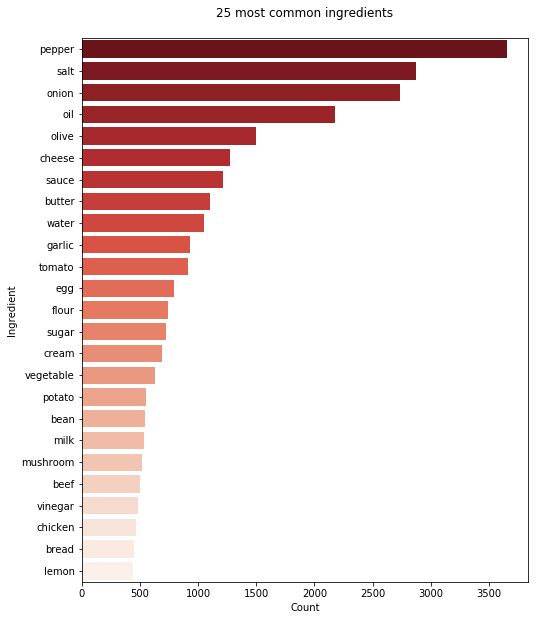

In [22]:
plot_ingredient(df_count, top_n=25)

# Topic Modeling

There is a total of 1058 unique words/ingredients. I want to **provide label/labels to each recipe** and then build a content-based recommender system. I decide to use topic modeling to group ingredients to topics (e.g. Italian, seafood, etc.) As a result, each recipe will have probability distribution across topics/labels. I may need to assign a name to each topic based on my judgement.

## LDA using gensim

### Create dictionary and corpus

In [25]:
# create Dictionary
id2word = corpora.Dictionary(data_clean)

# create corpus
texts = data_clean

# term doc frequency - mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in texts]

In [26]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1)]

In [27]:
# create tf-idf model and apply transformation to the entire corpus
# tfidf = TfidfModel(corpus)
# corpus_tfidf = tfidf[corpus]
# corpus_tfidf[0]

I decided not to use TF-IDF because each ingredient usually appears once in a recipe and they should be considered equally.

### Build LDA model

In [28]:
# Build LDA model using default settings
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=10, 
                         random_state=100,
                         chunksize=100, 
                         passes=10, 
                         per_word_topics=True)

# chunksize - how many docs are processed at a time in the training algorithm
# passes - how often we train the model on the entire corpus

In [29]:
# print keywords in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.076*"shrimp" + 0.074*"lemon" + 0.071*"pepper" + 0.069*"salmon" + '
  '0.058*"butter" + 0.054*"juice" + 0.051*"salt" + 0.045*"parsley" + '
  '0.039*"garlic" + 0.035*"cheese"'),
 (1,
  '0.125*"onion" + 0.105*"pepper" + 0.102*"salt" + 0.089*"celery" + '
  '0.088*"potato" + 0.086*"carrot" + 0.064*"water" + 0.042*"pea" + '
  '0.038*"beef" + 0.025*"paprika"'),
 (2,
  '0.172*"cream" + 0.090*"onion" + 0.076*"cheese" + 0.072*"soup" + '
  '0.059*"pepper" + 0.057*"corn" + 0.042*"sour" + 0.033*"potato" + '
  '0.030*"cheddar" + 0.024*"tomato"'),
 (3,
  '0.102*"salt" + 0.101*"bread" + 0.099*"butter" + 0.086*"milk" + 0.081*"egg" '
  '+ 0.073*"flour" + 0.067*"pepper" + 0.043*"crumb" + 0.028*"pork" + '
  '0.026*"oil"'),
 (4,
  '0.223*"cheese" + 0.087*"egg" + 0.077*"mustard" + 0.055*"onion" + '
  '0.052*"mayonnaise" + 0.050*"cheddar" + 0.041*"dijon" + 0.033*"parmesan" + '
  '0.032*"ham" + 0.027*"swiss"'),
 (5,
  '0.092*"onion" + 0.090*"pepper" + 0.072*"chicken" + 0.062*"broth" + '
  '0.053*"sa

In [30]:
# compute baseline Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 3))

# compute Perplexity: the lower the better
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', np.round(perplexity, 2)) 

Coherence Score:  0.378

Perplexity:  -4.87


In [31]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.077425  0.130642       1        1  14.715118
7      0.191500  0.072169       2        1  13.879384
5      0.094231  0.077143       3        1  12.432790
9      0.108179  0.046694       4        1  12.405619
3     -0.184251  0.104167       5        1   9.070283
2      0.000284 -0.193835       6        1   8.667649
6     -0.342788  0.149999       7        1   8.144669
0      0.077331 -0.038108       8        1   7.971419
1      0.092938 -0.013048       9        1   6.751635
4     -0.114850 -0.335825      10        1   5.961421, topic_info=     Category         Freq          Term        Total  loglift  logprob
32    Default  1287.000000        cheese  1287.000000  30.0000  30.0000
36    Default  1456.000000         olive  1456.000000  29.0000  29.0000
74    Default   691.000000         cream   691.000000  28.0000  28.0000
19    Default  1144.000000         sauce  1144.000000  27.0000  27.0000
37    Default   679.000000         sugar   679.000000  26.0000  26.0000
53    Default   823.000000           egg   823.000000  25.0000  25.0000
0     Default  2169.000000           oil  2169.000000  24.0000  24.0000
51    Default   589.000000      mushroom   589.000000  23.0000  23.0000
61    Default   423.000000         bread   423.000000  22.0000  22.0000
34    Default   737.000000         flour   737.000000  21.0000  21.0000
31    Default  1108.000000        butter  1108.000000  20.0000  20.0000
54    Default   570.000000          milk   570.000000  19.0000  19.0000
11    Default   401.000000        celery   401.000000  18.0000  18.0000
1     Default   592.000000        potato   592.000000  17.0000  17.0000
99    Default   453.000000       chicken   453.000000  16.0000  16.0000
79    Default   347.000000        carrot   347.000000  15.0000  15.0000
120   Default   358.000000         broth   358.000000  14.0000  14.0000
13    Default   415.000000         lemon   415.000000  13.0000  13.0000
29    Default   577.000000          bean   577.000000  12.0000  12.0000
84    Default   278.000000        shrimp   278.000000  11.0000  11.0000
221   Default   292.000000          soup   292.000000  10.0000  10.0000
14    Default  2712.000000         onion  2712.000000   9.0000   9.0000
15    Default   252.000000        salmon   252.000000   8.0000   8.0000
28    Default   249.000000       mustard   249.000000   7.0000   7.0000
7     Default   358.000000         juice   358.000000   6.0000   6.0000
217   Default   312.000000           soy   312.000000   5.0000   5.0000
8     Default  3549.000000        pepper  3549.000000   4.0000   4.0000
33    Default   293.000000          corn   293.000000   3.0000   3.0000
30    Default   281.000000         brown   281.000000   2.0000   2.0000
132   Default   257.000000       cheddar   257.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
376   Topic10     4.310118       segment     5.205317   2.6311  -6.4577
757   Topic10     4.125677      beverage     5.021001   2.6235  -6.5014
585   Topic10     3.975616        double     4.870787   2.6168  -6.5385
104   Topic10     3.768437          mein     4.663858   2.6067  -6.5920
522   Topic10     3.602314        relish     4.497493   2.5979  -6.6371
949   Topic10     3.381878   morningstar     4.277349   2.5850  -6.7002
1047  Topic10     3.233965    equivalent     4.129508   2.5754  -6.7449
698   Topic10     3.051828       gruyere     3.947013   2.5626  -6.8029
12    Topic10    68.701439          dill    97.979897   2.4649  -3.6889
1003  Topic10     1.996389           dip     2.891621   2.4494  -7.2273
986   Topic10     1.990088  southwestern     2.885496   2.4483  -7.2305
97    Topic10    18.150082         grape    27.001911   2.4226  -5.0200
428   Topic10     1.788266    maraschino     2.683398   2.4140  -7.3374
111   Topic10    72.684578         bacon   116.016762   2.3523  -3.63

### Tune hyperparameters 

In [32]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k, 
                             random_state=100,
                             chunksize=100,
                             passes=10,
                             alpha=a,
                             eta=b,
                             per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [33]:
# topics range
topics_range = range(2, 16, 1)

# alpha parameter
alpha = [0.01, 0.1, 1, 'symmetric', 'asymmetric']

# beta parameter
beta = [0.01, 0.1, 1, 'symmetric']

# validation sets
num_of_docs = len(corpus)
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

In [35]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=350)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, 
                                              dictionary=id2word, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


 80%|████████  | 280/350 [46:43<12:04, 10.36s/it]

In [7]:
df_result = pd.read_csv('lda_tuning_results.csv')
df_result.head()

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.354678
1,2,0.01,0.1,0.346927
2,2,0.01,1,0.350990
3,2,0.01,symmetric,0.346364
4,2,0.1,0.01,0.346927


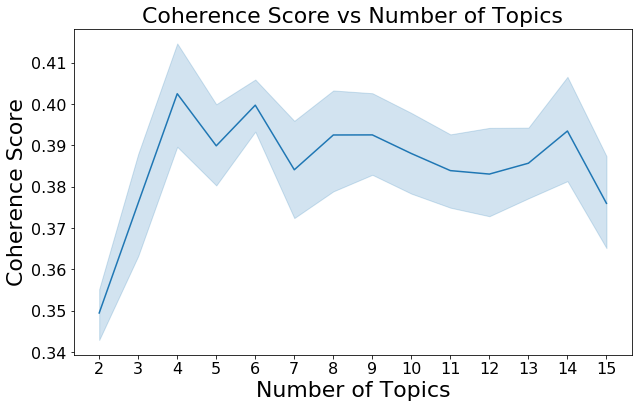

In [15]:
# visualize c_v score vs # topics 
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_result, x='Topics', y='Coherence')
plt.xticks(range(2, 16, 1), range(2, 16, 1), fontsize='16')
plt.yticks(fontsize='16')
plt.xlabel('Number of Topics', fontsize='22')
plt.ylabel('Coherence Score', fontsize='22')
plt.title('Coherence Score vs Number of Topics', fontsize='22');

#### The best number of topics is among 6 to 10.

In [44]:
# look for the best alpha and beta based on c_v score
df_result[df_result.Topics == 8].sort_values('Coherence', ascending=False)[:5]

,Topics,Alpha,Beta,Coherence
139,8,0.01,1,0.438717
143,8,0.1,1,0.433839
151,8,symmetric,1,0.417886
138,8,0.01,0.1,0.415906
144,8,0.1,symmetric,0.412666


With **k of 8, alpha of 0.1 and beta of 1**, I can achieve 14.6% improvement in coherence score over the baseline.

In [49]:
# build the final model
lda_model_final = LdaMulticore(corpus=corpus,
                               id2word=id2word,
                               num_topics=8, 
                               random_state=100,
                               chunksize=100,
                               passes=10,
                               alpha=0.1,
                               eta=1)

In [50]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.156231  0.015349       1        1  17.764750
6      0.143889 -0.035284       2        1  16.878305
5      0.062800  0.097933       3        1  15.883822
0      0.081258 -0.088130       4        1  15.447731
2     -0.078049 -0.173267       5        1  14.271852
3     -0.030271  0.179997       6        1   7.666449
4     -0.252072  0.024361       7        1   7.281665
1     -0.083786 -0.020958       8        1   4.805423, topic_info=     Category         Freq             Term        Total  loglift  logprob
32    Default  1050.000000           cheese  1050.000000  30.0000  30.0000
1     Default   482.000000           potato   482.000000  29.0000  29.0000
19    Default  1064.000000            sauce  1064.000000  28.0000  28.0000
37    Default   597.000000            sugar   597.000000  27.0000  27.0000
74    Default   616.000000            cream   616.000000  26.0000  26.0000
31    Default   944.000000           butter   944.000000  25.0000  25.0000
36    Default  1278.000000            olive  1278.000000  24.0000  24.0000
34    Default   612.000000            flour   612.000000  23.0000  23.0000
0     Default  1896.000000              oil  1896.000000  22.0000  22.0000
29    Default   500.000000             bean   500.000000  21.0000  21.0000
61    Default   351.000000            bread   351.000000  20.0000  20.0000
53    Default   655.000000              egg   655.000000  19.0000  19.0000
54    Default   471.000000             milk   471.000000  18.0000  18.0000
3     Default   584.000000        vegetable   584.000000  17.0000  17.0000
10    Default   801.000000           tomato   801.000000  16.0000  16.0000
50    Default   339.000000          italian   339.000000  15.0000  15.0000
13    Default   358.000000            lemon   358.000000  14.0000  14.0000
8     Default  3131.000000           pepper  3131.000000  13.0000  13.0000
221   Default   262.000000             soup   262.000000  12.0000  12.0000
71    Default   419.000000             beef   419.000000  11.0000  11.0000
28    Default   182.000000          mustard   182.000000  10.0000  10.0000
217   Default   280.000000              soy   280.000000   9.0000   9.0000
51    Default   530.000000         mushroom   530.000000   8.0000   8.0000
30    Default   257.000000            brown   257.000000   7.0000   7.0000
114   Default   147.000000            crumb   147.000000   6.0000   6.0000
132   Default   200.000000          cheddar   200.000000   5.0000   5.0000
18    Default   240.000000              hot   240.000000   4.0000   4.0000
21    Default   113.000000       mayonnaise   113.000000   3.0000   3.0000
7     Default   314.000000            juice   314.000000   2.0000   2.0000
181   Default   257.000000             pork   257.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
401    Topic8     4.561198         broccoli    19.028645   1.6071  -6.1855
356    Topic8     1.916478         hawaiian     8.283011   1.5717  -7.0526
687    Topic8     4.215637             peel    18.392550   1.5623  -6.2643
1021   Topic8     1.830611         charcoal     8.273080   1.5271  -7.0985
306    Topic8     1.963803   english_muffin     8.965517   1.5169  -7.0282
981    Topic8     1.724734         gram_yve     7.982780   1.5032  -7.1580
979    Topic8     1.951043   veggie_cuisine     9.058987   1.5000  -7.0347
855    Topic8     2.036168          parsnip     9.515092   1.4936  -6.9920
98     Topic8     4.540139             tuna    21.288176   1.4902  -6.1901
625    Topic8     1.995919             sole     9.359809   1.4901  -7.0120
522    Topic8     1.909142           relish     9.159081   1.4673  -7.0565
649    Topic8     2.157837       breadcrumb    10.383353   1.4643  -6.9340
188    Topic8    23.925325          paprika   131.654922   1.3302  -4.5282
211    Topic8     9.820754             mea

In [51]:
pyLDAvis.save_html(LDAvis_prepared, 'recipe_lda.html')

In [52]:
# print keywords in the 8 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.094*"pepper" + 0.076*"salt" + 0.063*"butter" + 0.044*"lemon" + '
  '0.041*"onion" + 0.041*"oil" + 0.035*"olive" + 0.030*"chicken" + '
  '0.029*"thyme" + 0.028*"juice"'),
 (1,
  '0.109*"potato" + 0.057*"mustard" + 0.048*"mayonnaise" + 0.035*"sweet" + '
  '0.033*"onion" + 0.031*"salt" + 0.029*"dijon" + 0.027*"pepper" + '
  '0.023*"celery" + 0.021*"dill"'),
 (2,
  '0.085*"cheese" + 0.084*"cream" + 0.071*"onion" + 0.049*"pepper" + '
  '0.046*"butter" + 0.044*"mushroom" + 0.043*"salt" + 0.039*"soup" + '
  '0.038*"milk" + 0.036*"potato"'),
 (3,
  '0.074*"bread" + 0.072*"oil" + 0.058*"vegetable" + 0.040*"crumb" + '
  '0.039*"egg" + 0.035*"ginger" + 0.031*"sauce" + 0.029*"soy" + 0.027*"onion" '
  '+ 0.021*"water"'),
 (4,
  '0.099*"sugar" + 0.087*"flour" + 0.065*"salt" + 0.058*"egg" + 0.055*"butter" '
  '+ 0.048*"milk" + 0.039*"brown" + 0.034*"water" + 0.019*"walnut" + '
  '0.014*"cranberry"'),
 (5,
  '0.105*"sauce" + 0.087*"pepper" + 0.064*"onion" + 0.049*"salt" + '
  '0.040*"beef" +

In [53]:
doc_lda[0]

[(0, 0.020843644),
 (1, 0.3772719),
 (2, 0.020839507),
 (3, 0.4976753),
 (4, 0.020840367),
 (5, 0.020840487),
 (6, 0.020843308),
 (7, 0.020845495)]

In [54]:
# create a df to show lda matrix
lda_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5:[], 6:[], 7:[]}

for _ in range(len(doc_lda)):
    for key in list(lda_dict.keys()):
        lda_dict[key].append(0)

# create a df filled with 0
lda_matrix = pd.DataFrame(lda_dict)

# fill the probability distribution of topics for each row
for i, row in enumerate(doc_lda):
    for j, (topic, prop_topic) in enumerate(row):
        lda_matrix.loc[i, topic] = prop_topic

In [55]:
lda_matrix.head()

,0,1,2,3,4,5,6,7
0,0.020844,0.377264,0.020840,0.497684,0.020840,0.020840,0.020843,0.020845
1,0.010209,0.378751,0.010208,0.010208,0.010208,0.010213,0.010208,0.559996
2,0.910242,0.012826,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823
3,0.012827,0.012826,0.012825,0.012824,0.012823,0.910223,0.012825,0.012827
4,0.000000,0.738248,0.000000,0.000000,0.000000,0.000000,0.210886,0.000000


In [56]:
# add recipe name
lda_matrix = lda_matrix.merge(df, left_index=True, right_index=True, how='inner')
lda_matrix.head()

,0,1,2,3,4,5,6,7,title,ingredients
0,0.020844,0.377264,0.020840,0.497684,0.020840,0.020840,0.020843,0.020845,Chip Truck Fries,"6 baking potatoes, cut into 1/4 inch slices,1/..."
1,0.010209,0.378751,0.010208,0.010208,0.010208,0.010213,0.010208,0.559996,Irish Bacon And Cabbage Soup,"1/2 pound Irish bacon, diced,2 large potatoes,..."
2,0.910242,0.012826,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823,Quick Salmon Salad,"2 (6 ounce) cans pink salmon, drained,1/2 cup ..."
3,0.012827,0.012826,0.012825,0.012824,0.012823,0.910223,0.012825,0.012827,Bills Seasoned Ketchup,"1 (28 ounce) bottle ketchup,2 teaspoons hot pe..."
4,0.000000,0.738248,0.000000,0.000000,0.000000,0.000000,0.210886,0.000000,Celery Salad,"3/4 cup sliced celery,1/3 cup dried sweet cher..."


In [57]:
# assign topic names using my judgement
lda_matrix.sort_values(by=0, ascending=False)[:5]
# topic 0 looks like seafood

,0,1,2,3,4,5,6,7,title,ingredients
1618,0.960668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Chef Johns Grilled Garlic And Herb Shrimp,"1 1/2 teaspoons kosher salt,1/2 teaspoon lemon..."
2343,0.960667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Seared Salmon With Indian Inspired Cream Sauce,"4 (6 ounce) fillets fresh salmon,salt and blac..."
3085,0.958326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Filet Mignon With Garlic Shrimp Cream Sauce,2 (4 ounce) 1 1/2 inch thick filet mignon stea...
1454,0.955690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Shrimp Scampi With Pasta,"1 (16 ounce) package linguine pasta,2 tablespo..."
3476,0.955689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Absolutely The Best Shrimp Scampi,"1/2 cup all-purpose flour,1/4 teaspoon salt,1/..."


In [58]:
lda_matrix.sort_values(by=1, ascending=False)[:5]
# topic 1 looks like salad

,0,1,2,3,4,5,6,7,title,ingredients
934,0.000000,0.945299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,New Wife Tuna Salad,"4 (5 ounce) cans tuna, drained,5 hard-boiled e..."
275,0.000000,0.940662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Imas Potato Salad,"2 pounds russet potatoes, peeled,3/4 cup mayon..."
304,0.010207,0.928555,0.010206,0.010206,0.010206,0.010206,0.010207,0.010207,Potato Salad Deviled Eggs,"8 eggs,1 large potato, coarsely chopped,2 teas..."
938,0.010207,0.928551,0.010207,0.010206,0.010207,0.010207,0.010207,0.010208,Amish Macaroni Salad,"2 cups uncooked elbow macaroni,3 hard-cooked e..."
279,0.010207,0.928550,0.010207,0.010206,0.010207,0.010207,0.010207,0.010208,Hawaiian Bruddah Potato Mac Macaroni Salad,"5 eggs,7 large potatoes, peeled and cubed,1 cu..."


In [59]:
lda_matrix.sort_values(by=2, ascending=False)[:5]
# topic 2 looks like cream-based

,0,1,2,3,4,5,6,7,title,ingredients
1442,0.0,0.0,0.962754,0.0,0.0,0.0,0.0,0.0,Cheater Pierogi,"2 teaspoons butter,4 slices bacon, chopped,2 t..."
3541,0.0,0.0,0.958326,0.0,0.0,0.0,0.0,0.0,Crawfish Chowder,"1/4 cup butter,1/2 bunch green onions, chopped..."
4567,0.0,0.0,0.958325,0.0,0.0,0.0,0.0,0.0,Seafood Chowder,"1 1/2 cups fat free milk,1 (8 ounce) container..."
1392,0.0,0.0,0.958322,0.0,0.0,0.0,0.0,0.0,Chef Johns Turkey Noodle Casserole,"12 ounces egg noodles,3 tablespoons butter,3 t..."
3216,0.0,0.0,0.955690,0.0,0.0,0.0,0.0,0.0,Ultimate Breakfast Casserole,"3 eggs, beaten,1 pinch ground black pepper,1 (..."


In [60]:
lda_matrix.sort_values(by=3, ascending=False)[:5]
# topic 3 looks like Asian cuisine

,0,1,2,3,4,5,6,7,title,ingredients
2974,0.0,0.0,0.0,0.964639,0.0,0.0,0.0,0.0,Turkey Lettuce Wraps With Shiitake Mushrooms,"2 cups water,2 ounces mai fun (angel hair) ric..."
2909,0.0,0.0,0.0,0.962753,0.0,0.0,0.0,0.0,Sukhothai Pad Thai,"1/2 cup white sugar,1/2 cup distilled white vi..."
846,0.0,0.0,0.0,0.960667,0.0,0.0,0.0,0.0,Carries Pad Thai Salad,"1 (12 ounce) package dried rice noodles,1/2 cu..."
1030,0.0,0.0,0.0,0.952691,0.0,0.0,0.0,0.0,Cedar Planked Salmon,"3 (12 inch) untreated cedar planks,1/3 cup veg..."
3294,0.0,0.0,0.0,0.952690,0.0,0.0,0.0,0.0,Thai Stuffed Tofu,"2 (12 ounce) packages extra firm tofu,1/4 cup ..."


In [61]:
lda_matrix.sort_values(by=4, ascending=False)[:5]
# topic 4 looks like baking goods

,0,1,2,3,4,5,6,7,title,ingredients
51,0.0,0.0,0.0,0.0,0.958322,0.0,0.0,0.0,Danish Spiced Rye Bread Sigtebrod,"1 cup milk,1 cup water,3 tablespoons butter,1/..."
2024,0.0,0.0,0.0,0.0,0.949272,0.0,0.0,0.0,Chocolate Revel Bars,"3 cups quick cooking oats,2 1/2 cups all-purpo..."
2029,0.0,0.0,0.0,0.0,0.949272,0.0,0.0,0.0,Oatmeal Whoopie Pies,"2 cups packed brown sugar,3/4 cup butter,2 egg..."
3898,0.0,0.0,0.0,0.0,0.949267,0.0,0.0,0.0,Crisp Peach Cobbler,"6 large fresh peaches, pitted and cut into eig..."
2527,0.0,0.0,0.0,0.0,0.949255,0.0,0.0,0.0,Bird Seed Energy Bars,"4 cups old-fashioned rolled oats,1 cup brown s..."


In [62]:
lda_matrix.sort_values(by=5, ascending=False)[:5]
# topic 5 looks like meat

,0,1,2,3,4,5,6,7,title,ingredients
1664,0.0,0.0,0.0,0.0,0.0,0.973874,0.0,0.0,North Carolina Style Pulled Pork,"1 tablespoon mild paprika,2 teaspoons light br..."
3187,0.0,0.0,0.0,0.0,0.0,0.973873,0.0,0.0,Good New Orleans Creole Gumbo,"1 cup all-purpose flour,3/4 cup bacon dripping..."
1199,0.0,0.0,0.0,0.0,0.0,0.962753,0.0,0.0,Texas Pork Ribs,"6 pounds pork spareribs,1 1/2 cups white sugar..."
1630,0.0,0.0,0.0,0.0,0.0,0.962752,0.0,0.0,Home Cured Holiday Ham,"1 (7 pound) fresh, bone-in pork shoulder (""pic..."
1709,0.0,0.0,0.0,0.0,0.0,0.960668,0.0,0.0,Sticky Garlic Pork Chops,"For the Marinade and Sauce Mixture:,1/3 cup li..."


In [63]:
lda_matrix.sort_values(by=6, ascending=False)[:5]
# topic 6 looks like Italian cuisine

,0,1,2,3,4,5,6,7,title,ingredients
1544,0.0,0.0,0.0,0.0,0.0,0.0,0.964638,0.0,Chef Johns Spaghetti Al Tonno,"2 tablespoons olive oil,1 anchovy fillet,2 tab..."
1663,0.0,0.0,0.0,0.0,0.0,0.0,0.964636,0.0,Chef Johns Spaghetti With Red Clam Sauce,"2 tablespoons olive oil,3 cloves garlic,2 tabl..."
3299,0.0,0.0,0.0,0.0,0.0,0.0,0.962755,0.0,Disneys Ratatouille,"1 (6 ounce) can tomato paste,1/2 onion, choppe..."
87,0.0,0.0,0.0,0.0,0.0,0.0,0.960667,0.0,Easy Tomato Basil Pizza,"2 tomatoes, seeded and coarsely chopped,1 teas..."
1595,0.0,0.0,0.0,0.0,0.0,0.0,0.960664,0.0,Simple Spinach Lasagna,"1 tablespoon extra virgin olive oil,2 (10 ounc..."


In [64]:
lda_matrix.sort_values(by=7, ascending=False)[:5]
# topic 7 looks like Mexican

,0,1,2,3,4,5,6,7,title,ingredients
4437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.964643,The Best Vegetarian Chili In The World,"1 tablespoon olive oil,1/2 medium onion, chopp..."
338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.962757,Veggie Bulgur Salad Kisir,"1 cup fine bulgur,1 cup boiling water,2 tables..."
3195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960669,Quinoa And Black Bean Chili,"1 cup uncooked quinoa, rinsed,2 cups water,1 t..."
3242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960669,Turkey Taco Soup,"2 tablespoons olive oil,1 1/4 pounds ground tu..."
2311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.960663,Cornucopia Chili,"1 1/2 cups dry kidney beans,1 1/2 cups dried p..."


In [65]:
# drop ingredients columns 
lda_matrix.drop('ingredients', axis=1, inplace=True)

# change column name
lda_matrix.columns = ['seafood','salad','cream_based','asian','baking_goods','meat','italian','mexican','title']
lda_matrix.head()

,seafood,salad,cream_based,asian,baking_goods,meat,italian,mexican,title
0,0.020844,0.377264,0.020840,0.497684,0.020840,0.020840,0.020843,0.020845,Chip Truck Fries
1,0.010209,0.378751,0.010208,0.010208,0.010208,0.010213,0.010208,0.559996,Irish Bacon And Cabbage Soup
2,0.910242,0.012826,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823,Quick Salmon Salad
3,0.012827,0.012826,0.012825,0.012824,0.012823,0.910223,0.012825,0.012827,Bills Seasoned Ketchup
4,0.000000,0.738248,0.000000,0.000000,0.000000,0.000000,0.210886,0.000000,Celery Salad


In [66]:
lda_matrix.set_index('title', inplace=True)
lda_matrix.head()

,seafood,salad,cream_based,asian,baking_goods,meat,italian,mexican
title,,,,,,,,
Chip Truck Fries,0.020844,0.377264,0.020840,0.497684,0.020840,0.020840,0.020843,0.020845
Irish Bacon And Cabbage Soup,0.010209,0.378751,0.010208,0.010208,0.010208,0.010213,0.010208,0.559996
Quick Salmon Salad,0.910242,0.012826,0.012822,0.012821,0.012821,0.012822,0.012822,0.012823
Bills Seasoned Ketchup,0.012827,0.012826,0.012825,0.012824,0.012823,0.910223,0.012825,0.012827
Celery Salad,0.000000,0.738248,0.000000,0.000000,0.000000,0.000000,0.210886,0.000000


In [67]:
# save lda_matrix
lda_matrix.to_csv('recipe_lda.csv')

In [68]:
lda_matrix.shape

(4776, 8)

In [69]:
example = lda_matrix.loc[['Shrimp Scampi', 'Shrimp Linguine Alfredo']]

In [70]:
example

,seafood,salad,cream_based,asian,baking_goods,meat,italian,mexican
title,,,,,,,,
Shrimp Scampi,0.518918,0.011364,0.011366,0.011364,0.011364,0.011365,0.412893,0.011365
Shrimp Linguine Alfredo,0.559136,0.011364,0.011367,0.011365,0.011364,0.011365,0.372674,0.011366


In [71]:
example.loc['Shrimp Scampi']

seafood         0.518918
salad           0.011364
cream_based     0.011366
asian           0.011364
baking_goods    0.011364
meat            0.011365
italian         0.412893
mexican         0.011365
Name: Shrimp Scampi, dtype: float64

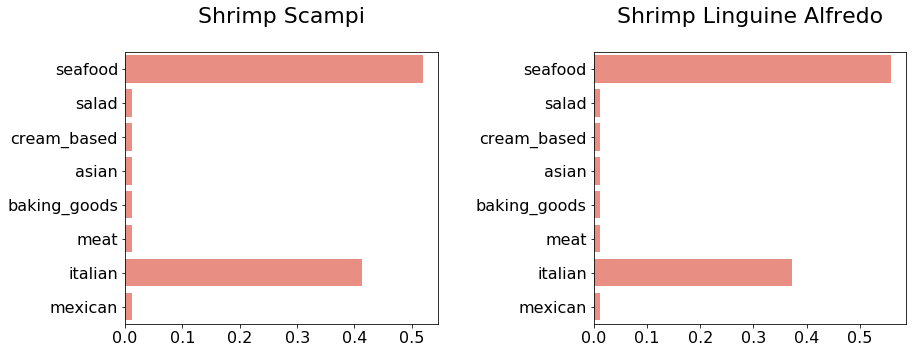

In [72]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=example.loc['Shrimp Scampi'], y=example.columns.tolist(), color='salmon')
plt.title('Shrimp Scampi\n', fontsize=22)
plt.xlabel('')
plt.xticks(fontsize='16')
plt.yticks(fontsize='16');

plt.subplot(1, 2, 2)
sns.barplot(x=example.loc['Shrimp Linguine Alfredo'], y=example.columns.tolist(), color='salmon')
plt.title('Shrimp Linguine Alfredo\n', fontsize=22)
plt.xlabel('')
plt.xticks(fontsize='16')
plt.yticks(fontsize='16')
plt.subplots_adjust(wspace=0.5);

References:

http://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/